In [1]:
# Importing Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set_style("darkgrid")
plt.style.use("fivethirtyeight")
from statsmodels.graphics.gofplots import qqplot
from pandas_profiling import ProfileReport
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import tensorflow as tf
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score

In [2]:
# Helpful Functions
def Numerical_Summary(dataframe,col):
    print("Numerical Summary of %s"%col)
    print("Skewness =",dataframe[col].skew())
    print("No of Missing Values =",dataframe[col].isnull().sum())
    print("Mean =",dataframe[col].mean())
    print("Median =",dataframe[col].median())
    print("Variance =",dataframe[col].var())
    print("Minimum =",dataframe[col].min())
    print("Maximum =",dataframe[col].max())
    print("Distribution of %s"%col)
    sns.histplot(dataframe[col].dropna())
    plt.show()
    print("="*50)
    print("Box-Plot of %s"%col)
    sns.boxplot(dataframe[col].dropna())
    plt.show()
    print("="*50)
    print("Qq-Plot of %s"%col)
    qqplot(dataframe[col].dropna(),line='s')
    plt.show()
    print("="*50)
    

# What is BigMart?
Big Mart Retail is a grocery supermarket brand, and it is widely known for its home delivery services of food and grocery. It enables the customer to walk away from the drudgery of grocery shopping and shop in a relaxed way of browsing from their home or office.

In [3]:
# Loading the data
train=pd.read_csv("../input/bigmart-sales-data/Train.csv")
test=pd.read_csv("../input/bigmart-sales-data/Test.csv")
train['file']='train'
test['file']='test'
print("No of Training Records =",len(train))
print("No of Testing Records =",len(test))
all_data=pd.concat([train,test])
all_data.head()

No of Training Records = 8523
No of Testing Records = 5681


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,file
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,train
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train


In [4]:
report=ProfileReport(all_data)
report.to_file("Big Mart Sales Report.html")

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Features Description
*     Item_Identifier: Product ID
*     Item_Weight: Weight of Product
*     Item_Fat_Content: Fat content of Product- Low/Regular
*     Item_Visibility: The % of total display area of all products in a store allocated to the particular product
*     Item_Type: Category of Product
*     Item_MRP: Maximum Retail Price of the Product
*     Outlet_Identifier: Store ID
*     Outlet_Establishment_Year: The Year in which store is established
*     Outlet_Size: Areawise distribution of Stores- Low/Medium/High
*     Outlet_Location_Type: Type of city in which outlet is located
*     Outlet_Type: Type of outlet - Grocery store or supermarket
*     Item_Outlet_Sales: Sale price of product - The dependant variable to be predicted
*     file- Identifier for train and test dataframes.


# Some Assumptions from understanding features:-
* Item_Weight will follow a Gaussian Distribution because the grocery  products will not have very high weights. Also we Item_mrp will follow a right-skew distribution because some grocery products will be costly.
* Many Stores will have same products and pricing of products should remain same throughout all stores on which it is available.
* Item_Visibiity of same products across different stores will differ.
* Generally now in 2021 people are more consicous about their diet so we except low quality fat products to be sold more then  high quality fat and also prices of low quality products will be more then high fat products.
* Sales of a product will depend on Outlet Location like stores which are on outskirts of a city will have low product sales as compared to a Store which is in centre of city.
* The Combinations of Product and Shop must not repeat.


In [5]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14204 entries, 0 to 5680
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            14204 non-null  object 
 1   Item_Weight                11765 non-null  float64
 2   Item_Fat_Content           14204 non-null  object 
 3   Item_Visibility            14204 non-null  float64
 4   Item_Type                  14204 non-null  object 
 5   Item_MRP                   14204 non-null  float64
 6   Outlet_Identifier          14204 non-null  object 
 7   Outlet_Establishment_Year  14204 non-null  int64  
 8   Outlet_Size                10188 non-null  object 
 9   Outlet_Location_Type       14204 non-null  object 
 10  Outlet_Type                14204 non-null  object 
 11  Item_Outlet_Sales          8523 non-null   float64
 12  file                       14204 non-null  object 
dtypes: float64(4), int64(1), object(8)
memory usage

In [6]:
all_data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,11765.000000,14204.000000,14204.000000,14204.000000,8523.000000
mean,12.792854,0.065953,141.004977,1997.830681,2181.288914
std,4.652502,0.051459,62.086938,8.371664,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.710000,0.027036,94.012000,1987.000000,834.247400
50%,12.600000,0.054021,142.247000,1999.000000,1794.331000
75%,16.750000,0.094037,185.855600,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


#  Analysing Individual Columns

In [7]:
print("No of Unique Products =",len(set(all_data['Item_Identifier'])))
print(all_data['Item_Identifier'].value_counts())

No of Unique Products = 1559
FDL45    10
FDU38    10
FDK33    10
FDD56    10
DRN47    10
         ..
FDH58     7
NCL42     7
FDI46     7
DRN11     7
FDX49     7
Name: Item_Identifier, Length: 1559, dtype: int64


In [8]:
print("No of Stores =",len(set(all_data['Outlet_Identifier'])))
print(all_data['Outlet_Identifier'].value_counts())

No of Stores = 10
OUT027    1559
OUT013    1553
OUT049    1550
OUT046    1550
OUT035    1550
OUT045    1548
OUT018    1546
OUT017    1543
OUT010     925
OUT019     880
Name: Outlet_Identifier, dtype: int64


* This obeys the assumption of combinations of products and stores should not be repeated so total products 1559 and total stores are 10 so total combinations will be 15590 and here we have total 14204 combinations. 

* In Item_Identifier FD stands for Food, NC stands for Non-Consumable, DR stands for Drinks.

Numerical Summary of Item_Weight
Skewness = 0.10130935278560388
No of Missing Values = 2439
Mean = 12.792854228644991
Median = 12.6
Variance = 21.645777525076852
Minimum = 4.555
Maximum = 21.35
Distribution of Item_Weight


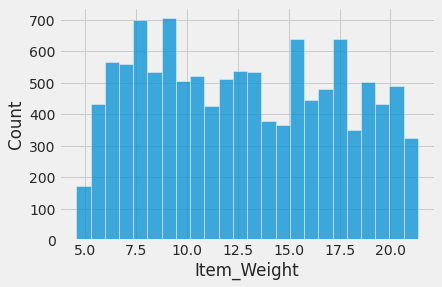

Box-Plot of Item_Weight


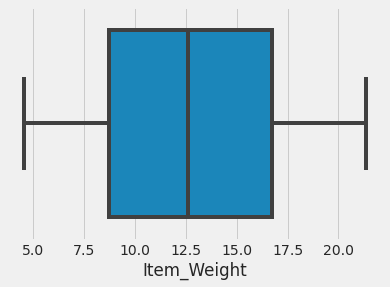

Qq-Plot of Item_Weight


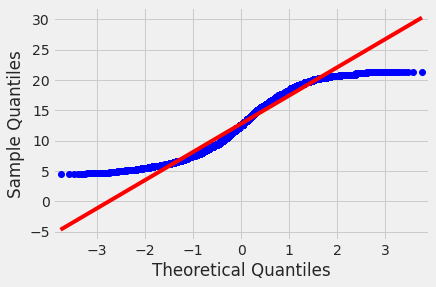

In [9]:
Numerical_Summary(all_data,"Item_Weight")

* The Missing Values are missing completely at random (MCAR) because there no missing values in item_fat,item_price,item_price.Since it is almost Normal and MCAR  we can impute it with mean or median.

In [10]:
print(all_data['Item_Fat_Content'].value_counts())

Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64


* So we can clearly see that LF,low fat,rf  are just misspelled creating another category so we can combine LF,low fat into Low Fat and reg into Regular

Numerical Summary of Item_Visibility
Skewness = 1.1951751774587882
No of Missing Values = 0
Mean = 0.06595278007399345
Median = 0.054020536499999994
Variance = 0.0026479870249410246
Minimum = 0.0
Maximum = 0.328390948
Distribution of Item_Visibility


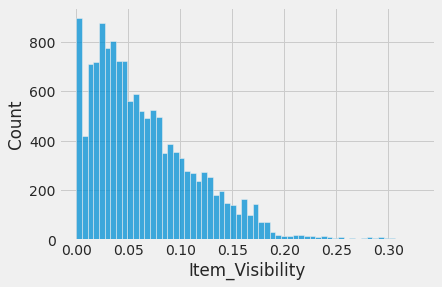

Box-Plot of Item_Visibility


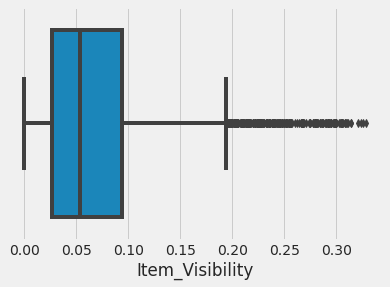

Qq-Plot of Item_Visibility


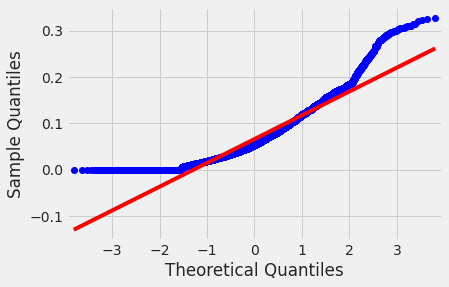

In [11]:
Numerical_Summary(all_data,'Item_Visibility')

* Also many points have item_visiblity of zero which does not make sense. Maybe the NAN values are encoded as zero.

Numerical Summary of Item_MRP
Skewness = 0.13072836040225866
No of Missing Values = 0
Mean = 141.00497725992656
Median = 142.247
Variance = 3854.7878720491467
Minimum = 31.29
Maximum = 266.8884
Distribution of Item_MRP


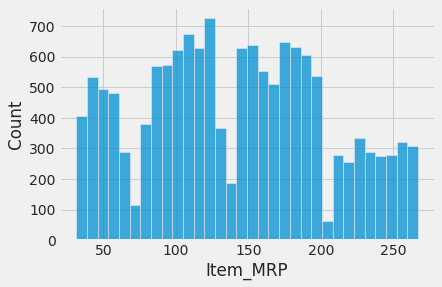

Box-Plot of Item_MRP


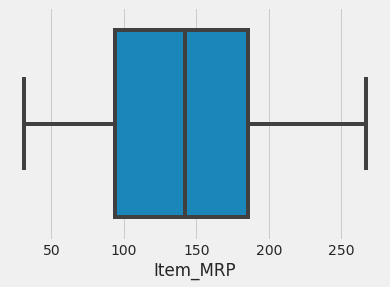

Qq-Plot of Item_MRP


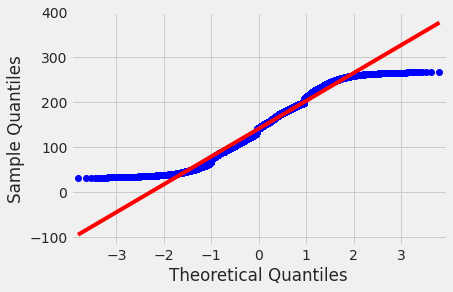

In [12]:
Numerical_Summary(all_data,"Item_MRP")

* My Assumption that it will follow a right skewed distribution is wrong  here as we can see skew is very less and it is a Multimodal Distribution

In [13]:
print(all_data['Outlet_Establishment_Year'].value_counts())

1985    2439
1987    1553
2004    1550
1997    1550
1999    1550
2002    1548
2009    1546
2007    1543
1998     925
Name: Outlet_Establishment_Year, dtype: int64


In [14]:
print(all_data['Outlet_Size'].value_counts())

Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64


This also mostly is MCAR so we can impute with Mode 

In [15]:
print(all_data['Outlet_Location_Type'].value_counts())

Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64


In [16]:
print(all_data['Outlet_Type'].value_counts())

Supermarket Type1    9294
Grocery Store        1805
Supermarket Type3    1559
Supermarket Type2    1546
Name: Outlet_Type, dtype: int64


Numerical Summary of Item_Outlet_Sales
Skewness = 1.1775306028542796
No of Missing Values = 5681
Mean = 2181.2889135750365
Median = 1794.331
Variance = 2912140.938499716
Minimum = 33.29
Maximum = 13086.9648
Distribution of Item_Outlet_Sales


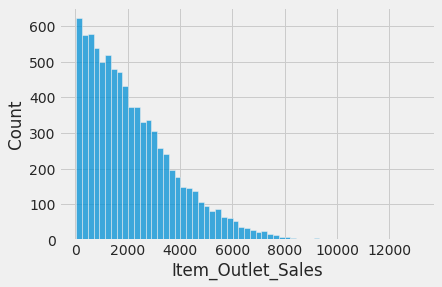

Box-Plot of Item_Outlet_Sales


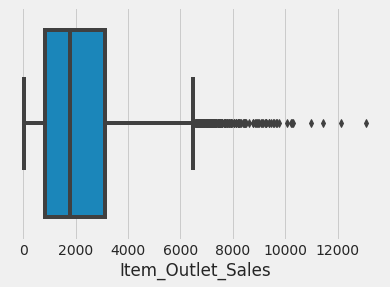

Qq-Plot of Item_Outlet_Sales


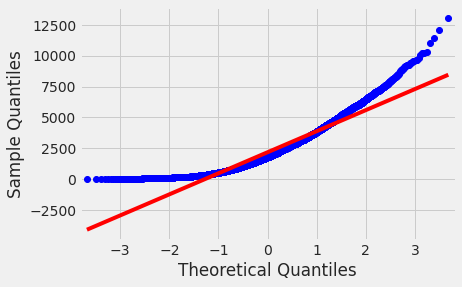

In [17]:
Numerical_Summary(all_data,"Item_Outlet_Sales")

The Missing Values are just because test set has no Item_Outlet_Sales Column.It is a right-skewed distribution so we can some transformations.

# BiVariate Analysis


In [18]:
df=all_data[~all_data['Item_Weight'].isna()]

In [19]:
fig=px.scatter(data_frame=train,x="Item_MRP",y="Item_Outlet_Sales",template="plotly_dark")
fig.show()

<Figure size 1080x1080 with 0 Axes>

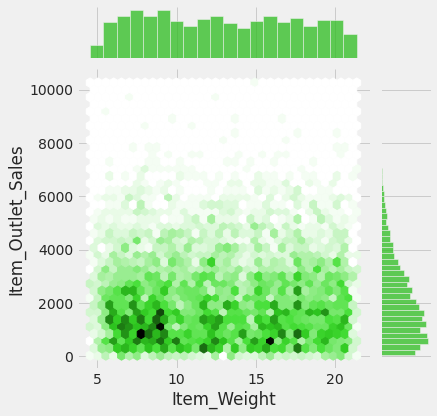

In [20]:
plt.figure(figsize=(15,15))
sns.jointplot(train['Item_Weight'],train['Item_Outlet_Sales'],kind='hex',color="#2CBD1E")
plt.show()

In [21]:
all_data['Item_Fat_Content'].replace(['low fat','LF','reg'],['Low Fat','Low Fat','Regular'],inplace = True)
all_data.groupby("Item_Fat_Content").agg({"Item_Visibility":"mean","Item_MRP":"mean","Item_Outlet_Sales":'mean'})

,Item_Visibility,Item_MRP,Item_Outlet_Sales
Item_Fat_Content,,,
Low Fat,0.064269,141.189424,2157.711534
Regular,0.069035,140.667431,2224.561170


In [22]:
all_data.groupby("Item_Type").agg({"Item_Visibility":"mean","Item_MRP":"mean","Item_Outlet_Sales":'mean'})

,Item_Visibility,Item_MRP,Item_Outlet_Sales
Item_Type,,,
Baking Goods,0.067898,127.458237,1952.971207
Breads,0.069553,141.389849,2204.132226
Breakfast,0.082463,137.985444,2111.808651
Canned,0.067836,138.620936,2225.194904
Dairy,0.071530,147.230998,2232.542597
Frozen Foods,0.067328,136.467385,2132.867744
Fruits and Vegetables,0.068571,144.304237,2289.009592
Hard Drinks,0.065712,137.295031,2139.221622
Health and Hygiene,0.056330,133.108079,2010.000265


In [23]:
all_data.groupby("Outlet_Size").agg({"Item_Visibility":"mean","Item_MRP":"mean","Item_Outlet_Sales":'mean'})

,Item_Visibility,Item_MRP,Item_Outlet_Sales
Outlet_Size,,,
High,0.060242,141.128428,2298.995256
Medium,0.059774,141.058775,2681.603542
Small,0.070872,140.917682,1912.149161


<AxesSubplot:>

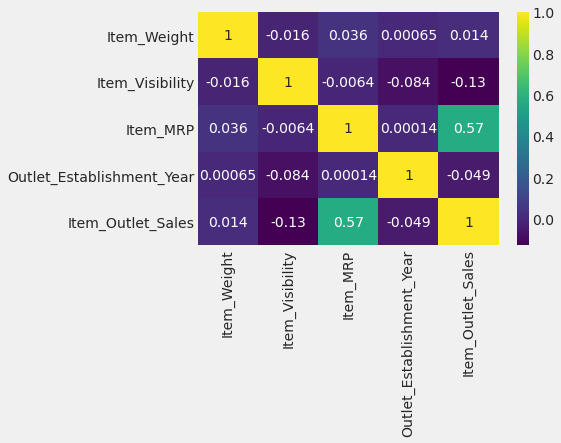

In [25]:
sns.heatmap(all_data.corr(),annot=True,cmap='viridis')

In [26]:
pd.crosstab(all_data['Outlet_Size'],all_data['Outlet_Location_Type'])

Outlet_Location_Type,Tier 1,Tier 2,Tier 3
Outlet_Size,,,
High,0,0,1553
Medium,1550,0,3105
Small,2430,1550,0


In [27]:
pd.crosstab(all_data['Outlet_Size'],all_data['Outlet_Type'])

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,,,,
High,0,1553,0,0
Medium,0,1550,1546,1559
Small,880,3100,0,0


In [28]:
pd.crosstab(all_data['Outlet_Size'],all_data['Outlet_Establishment_Year'])

Outlet_Establishment_Year,1985,1987,1997,1999,2004,2009
Outlet_Size,,,,,,
High,0,1553,0,0,0,0
Medium,1559,0,0,1550,0,1546
Small,880,0,1550,0,1550,0


In [29]:
pd.crosstab(all_data['Outlet_Size'],all_data['Outlet_Identifier'])

Outlet_Identifier,OUT013,OUT018,OUT019,OUT027,OUT035,OUT046,OUT049
Outlet_Size,,,,,,,
High,1553,0,0,0,0,0,0
Medium,0,1546,0,1559,0,0,1550
Small,0,0,880,0,1550,1550,0


In [30]:
pd.crosstab(all_data['Outlet_Location_Type'],all_data['Outlet_Type'])

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Location_Type,,,,
Tier 1,880,3100,0,0
Tier 2,0,4641,0,0
Tier 3,925,1553,1546,1559


All Outlet Columns are highly Correlated with Each Other